RedditNLProcessor.py is the main script that handles the pre-processing of the scrapped Reddit posts.  As with RedditScrapper.py, RedditNLProcessor.py can be run as a background thread or task pre-processing the posts at defined intervals.

#### 1. Retrieve all Reddit posts that requires pre-processing

Reddit posts that are pending pre-processing have the batch_id = 0.  A query to the database via the AWSDB interface, retrieves all Reddit posts with batch_id = 0.

#### 2. Pre-process the posts 

Each Reddit post undergodes a series of steps for pre-processing. For each Reddit post, a NLPPost is created and instantiated from it.  On initialization, the Reddit post's contents undergoes the following cleasning steps with the help of the NLPUtils.py module.

    2.1 Combined the contents of both the title and text within the post
    2.2 Using BeautifulSoup, remove all HTML tags
    2.3 Using regex, remove all digits, special characters and symbols
    2.4 All words are lower cased
    2.5 Stop words in the NLTK module are removed

In [ ]:
def post_to_words(text, my_stop_words=None):

    # Remove HTML tags
    text = BeautifulSoup(text, features='html5lib').get_text()

    # Remove digits and special characters
    letters_only = re.sub("[^a-zA-Z]", " ", text)

    # Convert to lower case and split into individual words
    words = letters_only.lower().split()

    # Get NLTK stop words
    stops = set(stopwords.words('english'))

    # Add new stop words using the my_stop_words parameter
    if my_stop_words is not None:
        stops.update(my_stop_words)

    # Remove stop words
    meaningful_words = [word for word in words if not word in stops]

    return meaningful_words

#### 3. Tokenization, Lemmatization, Stemming
    
At this point, the Reddit post has been processed to a collection of words meaningful for NLP. Next, I'll tokenized these words by lemmatization or stemming, or both.  RedditNLProcessor.py allows both tokenization methods via arguments 'lemmatize' and 'stem'.  I can also control the number of post to pre-process through the 'limit' parameter. Results of the tokenization is stored in the NLPPost object and later persist in the AWS database.

In [ ]:
# Check whether to lemmatize posts to tokens
if lemmatize:
    for post in nlp_posts:
        post.lemma_tokens = NLPUtils.lemmatize_words(post.words)

# Check whether to stem posts to tokens
if stem:
    for post in nlp_posts:
        post.stem_tokens = NLPUtils.stem_words(post.words)

#### 4. Store pre-processing results in database

The results of the cleansing and tokenization in the NLPPost instances are persisted in the posts_nlp table in the AWS MySQL database via the AWSDB interface. We can then use these results in future for count or TF-IDF  vectorization. Below is the posts_nlp table created using the MySQL Workbench.

    name - Unique Id that identifies a Reddit post
    subreddit - Sub-Reddit that the post belongs to
    batch_id - A running number that differentiates the pre-processed posts into batches
    contents - Combined contents of Reddit title and text
    words - Meaningful words after cleansing
    lemma_tokens - Tokens after lemmatization
    stem_tokens - Tokens after stemming


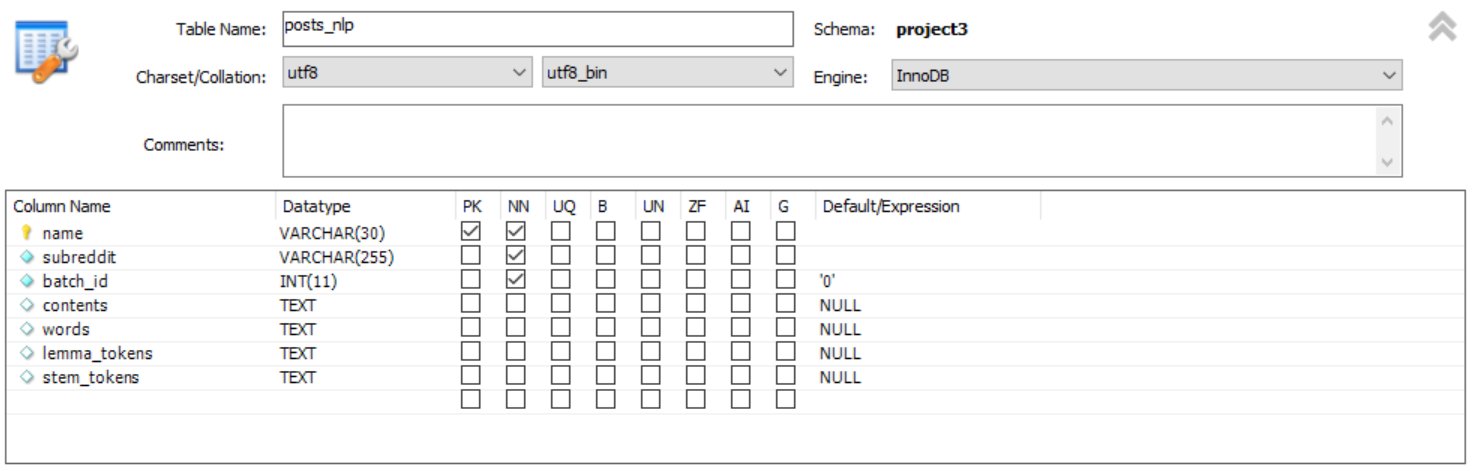

After inserting the NLP posts, I have to update the batch_id of the Reddit posts that were pre-processed on with a runninng number.